In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import pickle
import nltk
import lda
import re
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer 
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim import matutils
from sklearn.cluster import KMeans
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#export LC_ALL=en_US.UTF-8 (use this code for running NLTK)

/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# General Description
Being part of FLAG is the dream of most new grad students. Then,<b> How to be part of FLAG </b> will be an important question. This project wants to explore what's the best strategies for students of data-related field by analyzing Amazon's Job skills dataset. 

<b> Research Questions </b> of this project includes: 
1. What's the trend of Job Description in Amazon? What's the best time period to pursue career in Amazon? 
2. What's the data-related skills Amazon need? 
3. What's kind of talent and personality Amazon wants to have? 

This investigation is important because it allows new grad students to examine how well they fit to data related jobs in Amazon and also provides actionable insights for appliing jobs in Amazon.  

<b> Dataset Description: </b>

Amazon job dataset (Amazon_jobs_database.csv) is collected using Selenium and BeautifulSoup by scraping all of the jobs for Amazon job site from 2014 to 2018. 

<b> Content of Dataset </b>

1. Title: The title of the job
2. Location: Location of the job
3. Posting_date : Posting date of the job
4. Description: Overall description for the job
5. Basic Qualifications: Minimum Qualifications for the job
6. Preferred Qualifications: Preferred Qualifications for the job

# Table of Contents

1. Preparing the data
2. Research Question 1: What's the trend of posted data Jobs in Amazon? What's the best time period to pursue career in Amazon?
3. Research Question 2: What's the data-related skills Amazon need?
4. Research Question 3: What's kind of talent and personality Amazon wants to have?
5. Bonus Scene: Topic Analysis

# 1. Preparing the data

#### Select data-related jobs in Amazon from whole dataset 

In [2]:
df_Amazon = pd.read_csv('amazon_jobs_dataset.csv')
df_Amazon = df_Amazon.apply(lambda x: x.astype(str).str.upper())
df_Amazon['Posting_date'] = pd.to_datetime(df_Amazon['Posting_date'])
df_Amazon['Month'] = df_Amazon['Posting_date'].dt.month
df_Amazon['Year'] = df_Amazon['Posting_date'].dt.year
df_Amazon_data = df_Amazon.loc[df_Amazon.DESCRIPTION.str.contains(pat = 'DATA')]

# Research Question 1: What's the trend of posted data Jobs in Amazon? 

#### Step 1: Create the trend dataset of years and month. 

In [3]:
df_Trend_Year_Month = df_Amazon_data[(df_Amazon_data.Year == 2017) | (df_Amazon_data.Year == 2016) | 
               (df_Amazon_data.Year == 2015)].groupby(['Year','Month']).count()[['Posting_date']].reset_index()

#### Step 2: Draw a heatmap for discovering the hot zone between year and month.

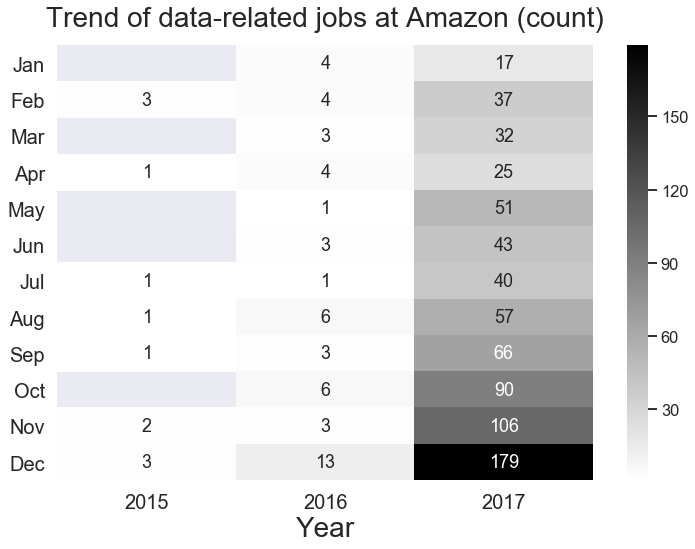

In [4]:
sns.set_context('talk')
sns.set_style('dark')
plt.figure(figsize = (12, 8))
sns.heatmap(df_Trend_Year_Month.pivot(index = 'Month', columns = 'Year', values = 'Posting_date'), 
            annot = True, fmt = "g", cmap = 'gray_r', yticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                                                                    'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Trend of data-related jobs at Amazon (count)', fontsize = 28,  y = 1.03)
plt.xlabel('Year', fontsize = 28)
plt.ylabel('', fontsize= 28)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20, rotation = 0)
plt.show()

## Insights of Q1
From this graph, we know two things: 
#### 1. Data jobs posted in Amazon was growing from 2015 to 2017.
#### 2. The fourth quarter is the best chance to apply Amazon data-related jobs especially in December. December got the maximum of posted jobs from 2015 to 2017.

This project also reveals the monthly trend of data-Related Jobs in Amazon. As you can see the graph below, it's obvious that the fourth quarter contribute all of jobs posted above annually average numbers for past 3 years. Submit your resume in fourth quarter will increase the chance of being a Amazoner. 

In [5]:
df_Trend_Month = df_Amazon_data[(df_Amazon_data.Year == 2017) | (df_Amazon_data.Year == 2016) | 
               (df_Amazon_data.Year == 2015)].groupby('Month').count()[['Posting_date']]
df_Trend_Month['AVG'] = df_Trend_Month.Posting_date.mean()
df_Trend_Month['Over_AVG'] = df_Trend_Month.Posting_date - df_Trend_Month.AVG
df_Trend_Month.loc[df_Trend_Month.Over_AVG < 0, 'Over_AVG'] = 0
df_Trend_Month['Below_AVG'] = df_Trend_Month.Posting_date - df_Trend_Month.Over_AVG

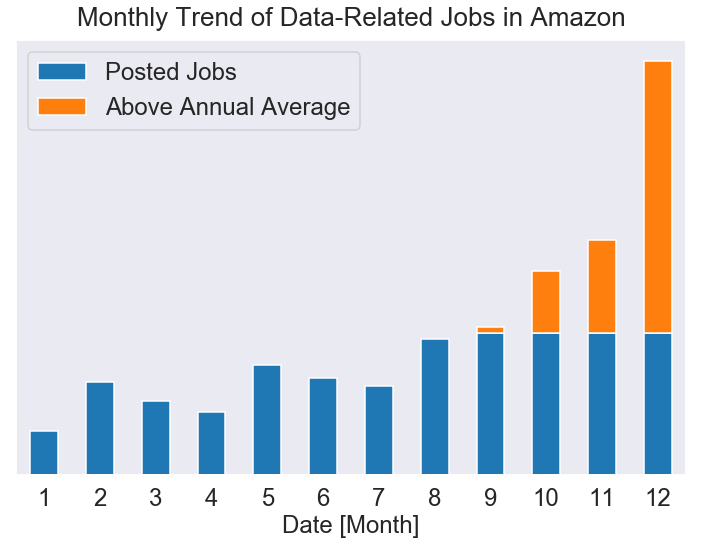

In [6]:
df_Trend_Month[['Below_AVG', 'Over_AVG']].plot(kind = 'bar', figsize =(12, 8), stacked = True)
plt.title('Monthly Trend of Data-Related Jobs in Amazon', 
          fontsize = 26, 
          y = 1.02)
plt.xlabel('Date [Month]', fontsize = 24)
plt.ylabel('') #hidden y label
plt.xticks(fontsize = 24, rotation = 0)
plt.yticks([])
plt.legend(['Posted Jobs', 'Above Annual Average'], 
           fontsize = 24);

# Research Question 2: What's the data-related skills Amazon need?

#### Step 1: Create the List of Popular Languages For Crunching Data  
source: https://www.fastcompany.com/3030716/the-9-best-languages-for-crunching-data

In [7]:
PopularLanguage = ['PYTHON', 'JAVA', 'Rlanguage', 'JULIA', 'SAS', 'SQL', 'MATLAB', #Convert R in to Rlanguage to catch it in text analysis
                   'SCALA', 'HADOOP', 'HIVE', 'KAFKA', 'OCTAVE', 'STORM', 'NOSQL']
PopularLanguage = [x.lower() for x in PopularLanguage] # LowerCase 

#### Step 2: Data Cleaning 

In [8]:
df_Amazon_data_text = df_Amazon_data[['DESCRIPTION', 'BASIC QUALIFICATIONS', 'PREFERRED QUALIFICATIONS']]

In [9]:
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace("/", " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace(",", " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace(".", " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace("·", " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace("(", " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace(")", " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace('“', " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace('"', " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace('?', " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace('!', " "))
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace('’', " "))

In [10]:
df_Amazon_data_text = df_Amazon_data_text.apply(lambda x: x.str.replace(" R ", " Rlanguage "))

#### Step 3: Create Document Term Matrix (DTM) to campare skills between 'BASIC QUALIFICATIONS' and  'PREFERRED QUALIFICATIONS' in Amazon

In [11]:
count_vectorizer_Basic_Q = CountVectorizer(stop_words = "english", 
                                           ngram_range = (1, 2))
df_Basic_Q = count_vectorizer_Basic_Q.fit_transform(df_Amazon_data_text['BASIC QUALIFICATIONS'])
df_Basic_Q = pd.DataFrame(df_Basic_Q.A, columns = count_vectorizer_Basic_Q.get_feature_names())

In [12]:
count_vectorizer_preferred_Q = CountVectorizer(stop_words = "english", 
                                           ngram_range = (1, 2))
df_preferred_Q = count_vectorizer_preferred_Q.fit_transform(df_Amazon_data_text['PREFERRED QUALIFICATIONS'])
df_preferred_Q = pd.DataFrame(df_preferred_Q.A, columns = count_vectorizer_preferred_Q.get_feature_names())

#### Step 4: Create Subset for Skills 

In [13]:
df_skills = pd.concat([df_Basic_Q.loc[:, PopularLanguage].fillna(0).sum().to_frame(), 
                          df_preferred_Q.loc[:, PopularLanguage].fillna(0).sum().to_frame()])
df_skills['PREFERRED'] = ([0] * 14) + ([1] * 14)
df_skills.columns = ['COUNT', 'PREFERRED']
df_skills['PRESENTAGE'] = ((df_skills['COUNT']) / df_Amazon_data_text['DESCRIPTION'].count())
df_skills = df_skills.reset_index()
df_skills['index'] = ['Python', 'Java', 'R', 'Julia', 'SAS', 'SQL', 'Matlab', 'Scala',
       'Hadoop', 'Hive', 'Kafka', 'Octave', 'Storm', 'NoSQL'] * 2
df_skills = df_skills[df_skills.PRESENTAGE > 0.01] #select skills over 1% of all data-related positions
df_skills['PREFERRED'] = df_skills.PREFERRED.apply(lambda x: str(x).replace('0', 'Basic Qualifications'))
df_skills['PREFERRED'] = df_skills.PREFERRED.apply(lambda x: str(x).replace('1', 'Preferred Qualifications'))
df_skills['PRESENTAGE'] = df_skills['PRESENTAGE'] * 100

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://

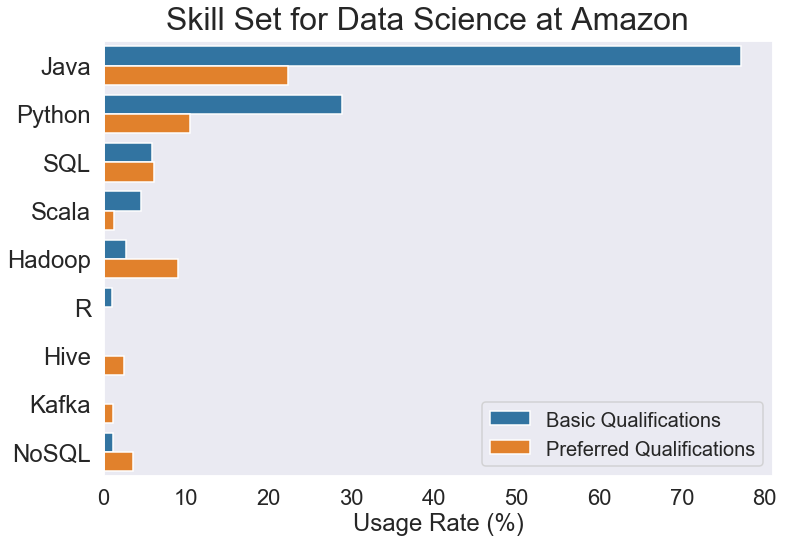

In [14]:
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Skill Set for Data Science at Amazon', fontsize = 32, y = 0.94)
sns.barplot(x = 'PRESENTAGE', 
            y = 'index', 
            data = df_skills, 
            hue = 'PREFERRED', 
            order = ['Java', 'Python', 'SQL', 'Scala', 'Hadoop', 'R', 'Hive', 'Kafka', 'NoSQL'])
plt.xlabel('Usage Rate (%)', fontsize = 24) #Data Skillset map 
plt.ylabel('')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 24)
plt.legend(loc = 'lower right', 
           fontsize = 20);

## Insights of Q2
There are some interesting insights in skills:

#### 1. Java is dominated language of data jobs at Amazon.
#### 2. R wouldn't make you be a strong applicant for jobs at Amazon.
#### 3. Languages, such as Hadoop, Hive, Kafka, NoSQL, increased a lot from Basic requirement to preferred requirement, which means that  Amazon hopes talents can handle large-scale data. 

## Research Question 3: What's kind of talent or personality Amazon wants to have?

#### Step 1: Tokenize Words in Dataset

In [15]:
Token_DESCRIPTION = []
for x in list(df_Amazon_data_text['DESCRIPTION'].index):
    Token_DESCRIPTION = Token_DESCRIPTION + word_tokenize(df_Amazon_data_text['DESCRIPTION'][x].lower())

In [16]:
Token_BASIC_QUALIFICATIONS = []
for x in list(df_Amazon_data_text['BASIC QUALIFICATIONS'].index):
    Token_BASIC_QUALIFICATIONS = Token_BASIC_QUALIFICATIONS + word_tokenize(
        df_Amazon_data_text['BASIC QUALIFICATIONS'][x].lower())

In [17]:
Token_PREFERRED_QUALIFICATIONS = []
for x in list(df_Amazon_data_text['PREFERRED QUALIFICATIONS'].index):
    Token_PREFERRED_QUALIFICATIONS = Token_PREFERRED_QUALIFICATIONS + word_tokenize(
        df_Amazon_data_text['PREFERRED QUALIFICATIONS'][x].lower())

#### Step 2: Lemmatize Words in Dataset And Combine them together

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()

In [19]:
lemmatize_DESCRIPTION = [wordnet_lemmatizer.lemmatize(x) for x in Token_DESCRIPTION]
lemmatize_BASIC_QUALIFICATIONS = [wordnet_lemmatizer.lemmatize(x) for x in Token_BASIC_QUALIFICATIONS]
lemmatize_PREFERRED_QUALIFICATIONS = [wordnet_lemmatizer.lemmatize(x) for x in Token_PREFERRED_QUALIFICATIONS]

In [20]:
lemmatize_All = lemmatize_PREFERRED_QUALIFICATIONS + lemmatize_BASIC_QUALIFICATIONS + lemmatize_DESCRIPTION

#### Step 3: Label Words in 'lemmatize_All' 

In [21]:
lemmatize_tag =  nltk.pos_tag(lemmatize_All)

#### Step 4: Filter Words Related to Personality and Talent 

In [22]:
word_of_bag_Amazon = []
for x in lemmatize_tag:
    if (x[1] == 'JJ'):
        word_of_bag_Amazon.append(x[0])

#### Step 5: Create DTM

In [23]:
count_vectorizer_Personality = CountVectorizer(stop_words = "english", 
                                           ngram_range = (1, 3))
df_Personality = count_vectorizer_Personality.fit_transform(word_of_bag_Amazon)
df_Personality = pd.DataFrame(df_Personality.A, columns = count_vectorizer_Personality.get_feature_names())

#### Step 6: Create word list for plotting wordclound 

In [24]:
df_Personality.sum()[df_Personality.sum() > 100].head() 
#Use frequency > 100 as the base to filter words related to personality

able           475
actual         161
advanced       145
affirmative    552
agile          518
dtype: int64

In [25]:
Personality = ['collaborative', 'cross functional', 'fast paced', 'flexible', 'innovative', 
               'internet facing', 'interpersonal', 'problem solving', 'quantitative', 'self directed', 
               'self starter', 'analytical', 'customer centric', 'creative', 'diverse', 'efficient', 'elastic', 
              'motivated', 'rapid', 'robust', 'strategic', 'team', 'verbal'] #List the words related to personality

In [26]:
df_Personality = df_Personality.sum()[Personality].to_frame().reset_index()
df_Personality.columns = ['words', 'values']

In [27]:
Personality_word_cloud = []
for x in df_Personality.index:
    Personality_word_cloud =  Personality_word_cloud + (
        [df_Personality.iloc[x].words] * df_Personality.iloc[x]['values'])

In [28]:
Personality_word_cloud = ' '.join(Personality_word_cloud)

In [29]:
Wordcloud = WordCloud(background_color = 'white', 
                        stopwords = STOPWORDS, 
                        collocations = False, 
                        max_words = 20, 
                        random_state = 32 ).generate(Personality_word_cloud)

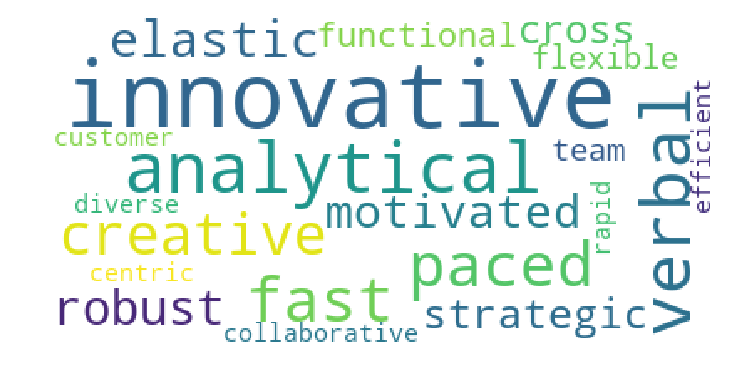

In [30]:
fig = plt.figure(figsize=(12,12))
plt.imshow(Wordcloud)
plt.axis('off')
plt.show()

## Insights of Q3
#### The ideal data person of Amazon is a person who are innovative, analytical thinking, fast paced, elastic, creative and be good at teamwork. Highlight and connect those characteristics with previous working experiece in resume will help to lending jobs at Amazon.

# Bonus Scene: Topic Analysis

#### Step 1: Convert Text Data into Corpus format

In [31]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [32]:
documents = lemmatize_All
texts = [tokenize(document) for document in documents]

In [33]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

#### Step 2: Run LDA Model

In [34]:
Amazon_topics = LdaModel(corpus = corpus,
                           id2word = dictionary,
                           num_topics = 5,
                           per_word_topics = 10)

#### Step 3: Check the Content of Topics

Topic 1

In [35]:
Amazon_topics.print_topics()[0][1]

'0.056*"customer" + 0.042*"engineer" + 0.037*"aws" + 0.034*"product" + 0.030*"build" + 0.028*"new" + 0.027*"building" + 0.023*"technical" + 0.019*"help" + 0.014*"learning"'

Topic 2

In [36]:
Amazon_topics.print_topics()[1][1]

'0.039*"business" + 0.033*"scale" + 0.031*"network" + 0.028*"world" + 0.023*"looking" + 0.018*"large" + 0.017*"like" + 0.017*"performance" + 0.017*"big" + 0.016*"need"'

Topic 3

In [37]:
Amazon_topics.print_topics()[2][1]

'0.096*"team" + 0.032*"experience" + 0.022*"distributed" + 0.019*"web" + 0.015*"way" + 0.015*"developer" + 0.014*"responsible" + 0.011*"come" + 0.010*"provide" + 0.009*"requirement"'

Topic 4

In [38]:
Amazon_topics.print_topics()[3][1]

'0.083*"software" + 0.070*"service" + 0.054*"data" + 0.046*"development" + 0.043*"technology" + 0.040*"work" + 0.027*"solution" + 0.023*"opportunity" + 0.021*"cloud" + 0.018*"database"'

Topic 5

In [39]:
Amazon_topics.print_topics()[4][1]

'0.118*"amazon" + 0.036*"design" + 0.030*"problem" + 0.028*"platform" + 0.024*"high" + 0.021*"working" + 0.016*"ll" + 0.015*"engineering" + 0.015*"quality" + 0.015*"management"'

## Insights of Bonus Scene
#### Basically, LDA model generate the random results for topic analysis, but we still can identify the text data of job description at Amazon as five main part: products,  customers, engineer, brand and teamwork (as above). 